# Project: Image Classification and Regression

In [1]:
import keras
from keras.utils import np_utils
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Activation,Dropout,BatchNormalization, Reshape
from keras.losses import mean_squared_error
from keras.optimizers import SGD
from keras.layers import Dense, Convolution2D, Flatten, MaxPooling2D
get_ipython().run_line_magic('matplotlib', 'inline')
import numpy as np
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Activation
from keras.models import Model
import random




/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

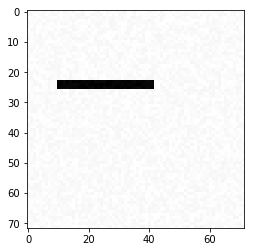

In [3]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


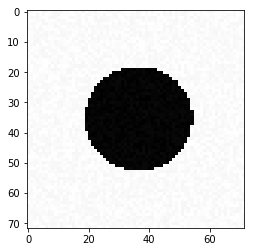

In [4]:
im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

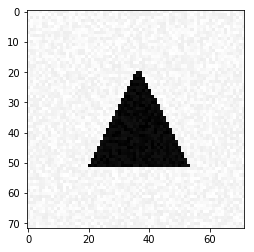

In [5]:
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


In [6]:
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]


# 3. Simple Classification

In [114]:
[X_train_1, Y_train_1] = generate_dataset_classification(3000, 20)
[X_test_1, Y_test_1] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2

In [115]:
X_train_1.shape


(3000, 5184)

In [116]:
Y_train_1 = to_categorical(Y_train_1)

In [117]:
Y_train_1.shape

(3000, 3)

## 3.1 stochastic gradient descent optimizer

In [118]:
model_1 = Sequential()
model_1.add(BatchNormalization(input_shape=(IMAGE_SIZE**2,)))
model_1.add(Dense(1024,input_shape=(5184,)))
model_1.add(Activation('relu'))
model_1.add(Dropout(0.2))
model_1.add(Dense(512,activation='relu'))
model_1.add(Dropout(0.2))
model_1.add(Dense(512,activation='relu'))
model_1.add(Dropout(0.2))
model_1.add(Dense(512,activation='relu'))
model_1.add(Dropout(0.2))
model_1.add(Dense(256,activation='relu'))
model_1.add(Dropout(0.2))
model_1.add(Dense(3,activation='softmax'))
sgd = SGD(lr=0.01,
decay=1e-6, momentum=0.9,
nesterov=True)
model_1.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model_1.fit(X_train_1, Y_train_1, epochs=5, batch_size=32,validation_split=0.3)


Train on 2100 samples, validate on 900 samples
Epoch 1/5
2100/2100 [==============================] - 9s 4ms/step - loss: 0.2896 - acc: 0.8652 - val_loss: 0.0046 - val_acc: 0.9989
Epoch 2/5
2100/2100 [==============================] - 7s 4ms/step - loss: 0.0378 - acc: 0.9876 - val_loss: 3.7681e-05 - val_acc: 1.0000
Epoch 3/5
2100/2100 [==============================] - 7s 4ms/step - loss: 0.0299 - acc: 0.9924 - val_loss: 2.7166e-04 - val_acc: 1.0000
Epoch 4/5
2100/2100 [==============================] - 7s 3ms/step - loss: 0.0022 - acc: 0.9990 - val_loss: 6.6589e-06 - val_acc: 1.0000
Epoch 5/5
2100/2100 [==============================] - 7s 3ms/step - loss: 0.0031 - acc: 0.9986 - val_loss: 6.2678e-06 - val_acc: 1.0000


In [119]:
X_test_1_1 = generate_a_rectangle()
X_test_1_1= X_test_1_1.reshape(1, X_test_1_1.shape[0])
model_1.predict(X_test_1_1)

array([[0., 0., 1.]], dtype=float32)

In [120]:
score_1 = model_1.evaluate(X_test_1, Y_test_1)

300/300 [==============================] - 0s 693us/step


In [121]:
print('Test loss:', score_1[0])
print('Test accuracy:', score_1[1])

Test loss: 6.934629262288412
Test accuracy: 0.3466666668653488


## 3.2 Adam optimizer

In [150]:
model_2 =Sequential()
model_2.add(BatchNormalization(input_shape=(IMAGE_SIZE**2,)))
model_2.add(Dense(1024,activation='tanh'))
model_2.add(Dropout(0.2))
model_2.add(Dense(512,activation='tanh'))
model_2.add(Dropout(0.2))
model_2.add(Dense(512,activation='tanh'))
model_2.add(Dropout(0.2))
model_2.add(Dense(512,activation='tanh'))
model_2.add(Dropout(0.2))
model_2.add(Dense(256,activation='tanh'))
model_2.add(Dropout(0.2))
model_2.add(Dense(3,activation='softmax'))

model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_2.fit(X_train_1, Y_train_1, epochs=5, batch_size=32,validation_split=0.3)

Train on 2100 samples, validate on 900 samples
Epoch 1/5
2100/2100 [==============================] - 14s 7ms/step - loss: 0.2511 - acc: 0.8919 - val_loss: 0.1627 - val_acc: 0.9400
Epoch 2/5
2100/2100 [==============================] - 10s 5ms/step - loss: 0.1279 - acc: 0.9600 - val_loss: 5.7061e-04 - val_acc: 1.0000
Epoch 3/5
2100/2100 [==============================] - 10s 5ms/step - loss: 0.0425 - acc: 0.9871 - val_loss: 0.2228 - val_acc: 0.9478
Epoch 4/5
2100/2100 [==============================] - 11s 5ms/step - loss: 0.0386 - acc: 0.9914 - val_loss: 7.2895e-04 - val_acc: 1.0000
Epoch 5/5
2100/2100 [==============================] - 9s 4ms/step - loss: 0.0047 - acc: 0.9990 - val_loss: 1.2237e-04 - val_acc: 1.0000


In [151]:
X_test_1_2 = generate_a_disk()
X_test_1_2= X_test_1_2.reshape(1, X_test_1_2.shape[0])
model_2.predict(X_test_1_2)

array([[3.4478938e-04, 1.3990643e-07, 9.9965513e-01]], dtype=float32)

In [152]:
score_2 = model_2.evaluate(X_test_1, Y_test_1)

300/300 [==============================] - 0s 717us/step


In [153]:
print('Test loss:', score_2[0])
print('Test accuracy:', score_2[1])

Test loss: 7.4925692240397135
Test accuracy: 0.39666666587193805


# 4. Visualization of the Solution
We would like to visualize the weights of the linear classifier. Check the output of the function model.get_weights(): The first part corresponds to the matrix of the classifier. Its columns have the same size as the input images, because Keras uses vector-matrix multiplications instead of matrix- vector multiplications.
† Visualize the 3 columns as images.
Hint: Only two (short) lines of code are required to visualize one column.


In [154]:
weight=model_2.get_weights()
weight

[array([0.98061067, 1.0012372 , 0.9826198 , ..., 0.99564075, 1.0026138 ,
        0.995977  ], dtype=float32),
 array([-0.00116132, -0.00278902,  0.00759406, ...,  0.00364438,
        -0.01221944, -0.01002611], dtype=float32),
 array([0.9660539 , 0.9658806 , 0.96589065, ..., 0.9668661 , 0.9661951 ,
        0.96613884], dtype=float32),
 array([0.0003746 , 0.00038241, 0.00037611, ..., 0.00038799, 0.00037984,
        0.00039107], dtype=float32),
 array([[ 0.00573435,  0.0137792 ,  0.01250196, ...,  0.01844514,
          0.02113938, -0.01050932],
        [-0.00088655,  0.01075573,  0.03753874, ...,  0.01914172,
          0.01514594,  0.00011212],
        [-0.00896223, -0.00292701, -0.01638826, ..., -0.01627011,
         -0.01310598,  0.01300451],
        ...,
        [-0.0126689 ,  0.02290948,  0.00826767, ..., -0.00917999,
         -0.01521821,  0.01960913],
        [ 0.02291162,  0.01100552, -0.00665879, ..., -0.00047922,
         -0.0138392 ,  0.00272148],
        [ 0.00415411,  0.031325

In [155]:
weight=model_2.get_weights()
for i in weight:
    print(i.shape)

(5184,)
(5184,)
(5184,)
(5184,)
(5184, 1024)
(1024,)
(1024, 512)
(512,)
(512, 512)
(512,)
(512, 512)
(512,)
(512, 256)
(256,)
(256, 3)
(3,)


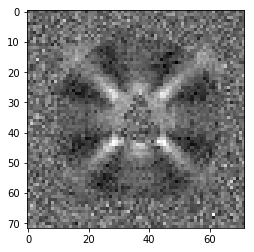

In [156]:
plt.imshow(weight[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

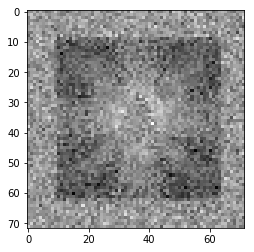

In [157]:
plt.imshow(weight[1].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

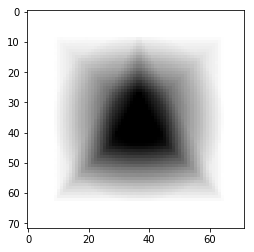

In [158]:
plt.imshow(weight[2].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

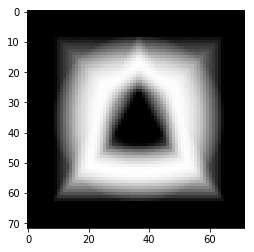

In [159]:
plt.imshow(weight[3].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

# 5. A More Difficult Classification Problem
Train a convolutional (not-to-)deep network on this new dataset. What is the value of the loss function on this test set when using your deep network?

Hints: You can limit yourself to 1 convolutional layer with 16 5×5 filters, 1 pooling layer, and one fully connected layer, but you are free to use any other architecture. You are allowed to increase the number of training samples if you want to.

In [7]:
[X_train_2, Y_train_2] = generate_dataset_classification(3000, 20, True)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2

In [8]:
[X_test_2, Y_test_2] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [9]:
Y_train_2 = to_categorical(Y_train_2)

In [10]:
Y_train_2.shape

(3000, 3)

In [11]:
Y_train_2[0]

array([0., 1., 0.], dtype=float32)

In [12]:
X_train_2.shape

(3000, 5184)

In [13]:
X_train_2 = X_train_2.reshape(X_train_2.shape[0], IMAGE_SIZE,IMAGE_SIZE,1)
X_train_2 = X_train_2.astype('float32')
X_test_2=X_test_2.reshape(X_test_2.shape[0], IMAGE_SIZE,IMAGE_SIZE,1)
X_test_2 = X_test_2.astype('float32')

In [14]:
#create model
model3 = Sequential()
#add model layers
model3.add(Convolution2D(16, kernel_size=5, activation='relu'))
model3.add(MaxPooling2D(pool_size=2,strides=2,padding='valid'))
model3.add(Dropout(0.25))
model3.add(Flatten())
model3.add(Dense(1024, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(1024, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(3, activation='softmax'))

model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model3.fit(X_train_2, Y_train_2, epochs=5, batch_size=32,validation_split=0.3)


Train on 2100 samples, validate on 900 samples
Epoch 1/5
2100/2100 [==============================] - 35s 17ms/step - loss: 1.2162 - acc: 0.5119 - val_loss: 0.6698 - val_acc: 0.7311
Epoch 2/5
2100/2100 [==============================] - 35s 17ms/step - loss: 0.5181 - acc: 0.8010 - val_loss: 0.4070 - val_acc: 0.8456
Epoch 3/5
2100/2100 [==============================] - 36s 17ms/step - loss: 0.2267 - acc: 0.9243 - val_loss: 0.3265 - val_acc: 0.8922
Epoch 4/5
2100/2100 [==============================] - 35s 17ms/step - loss: 0.1037 - acc: 0.9638 - val_loss: 0.2999 - val_acc: 0.9100
Epoch 5/5
2100/2100 [==============================] - 35s 17ms/step - loss: 0.0627 - acc: 0.9800 - val_loss: 0.2403 - val_acc: 0.9278


In [15]:
score3 = model3.evaluate(X_test_2, Y_test_2)

300/300 [==============================] - 1s 4ms/step


In [16]:
print('Test loss:', score3[0])
print('Test accuracy:', score3[1])

Test loss: 0.1978840398788452
Test accuracy: 0.9366666674613953


# 6. A Regression Problem
The task now is to predict the image locations of the vertices of a triangle, given an image of this triangle. 

In [67]:
[X_train_3, Y_train_3] = generate_dataset_regression(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


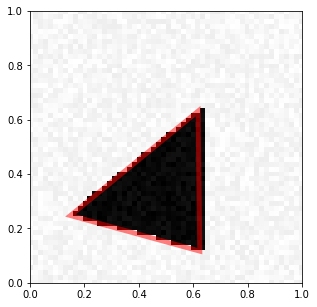

In [68]:
visualize_prediction(X_train_3[0], Y_train_3[0])

In [69]:
[X_test_3, Y_test_3] = generate_test_set_regression()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [70]:
X_train_3.shape

(300, 5184)

In [76]:
# define regression model
def regression_model():
    # create model
    model= Sequential()
    model.add(BatchNormalization(input_shape=(IMAGE_SIZE**2,)))
    model.add(Reshape((IMAGE_SIZE,IMAGE_SIZE,1)))
    model.add(Convolution2D(16, kernel_size=5, activation='relu'))
    model.add(MaxPooling2D(pool_size=2,strides=2,padding='valid'))
    model.add(Convolution2D(32, kernel_size=8, activation='relu'))
    model.add(MaxPooling2D(pool_size=2,strides=2,padding='valid'))
    model.add(Convolution2D(64, kernel_size=10, activation='relu'))
    model.add(MaxPooling2D(pool_size=2,strides=2,padding='valid'))
    
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(6))
    # compile model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [77]:
# build the model
model4 = regression_model()

# fit the model
model4.fit(X_train_3, Y_train_3, epochs=30, batch_size=32,validation_split=0.3)

Train on 210 samples, validate on 90 samples
Epoch 1/30
210/210 [==============================] - 4s 20ms/step - loss: 0.5791 - val_loss: 0.3005
Epoch 2/30
210/210 [==============================] - 2s 11ms/step - loss: 0.2830 - val_loss: 0.1618
Epoch 3/30
210/210 [==============================] - 2s 12ms/step - loss: 0.1338 - val_loss: 0.0861
Epoch 4/30
210/210 [==============================] - 2s 11ms/step - loss: 0.0873 - val_loss: 0.0853
Epoch 5/30
210/210 [==============================] - 2s 11ms/step - loss: 0.0841 - val_loss: 0.0838
Epoch 6/30
210/210 [==============================] - 2s 11ms/step - loss: 0.0836 - val_loss: 0.0786
Epoch 7/30
210/210 [==============================] - 2s 11ms/step - loss: 0.0820 - val_loss: 0.0818
Epoch 8/30
210/210 [==============================] - 3s 13ms/step - loss: 0.0806 - val_loss: 0.0763
Epoch 9/30
210/210 [==============================] - 3s 13ms/step - loss: 0.0789 - val_loss: 0.0770
Epoch 10/30
210/210 [=========================

In [78]:
model4.evaluate(X_test_3, Y_test_3)

300/300 [==============================] - 1s 3ms/step


0.07155124147733052

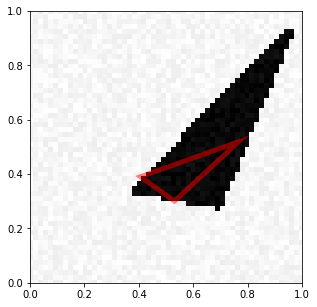

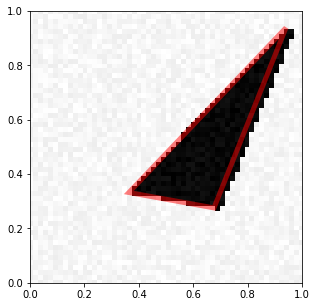

In [79]:
i= 0
visualize_prediction(X_test_3[i], model4.predict(X_test_3)[i])
visualize_prediction(X_test_3[i], Y_test_3[i])

# 7. Image Denoising
Implement a hourglass network for denoising: Modifying the generate_a_* functions to generate pairs of images, where one image has noise with random amplitude, and the second image has the same content but without the noise. Train your network to predict a noise-free image given a noisy image as input.

In [7]:
def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    x = generate_a_drawing(figsize, U, V, noise)
    y = generate_a_drawing(figsize, U, V, 0)
    return [x, y]

def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    x = generate_a_drawing(figsize, U, V, noise)
    y = generate_a_drawing(figsize, U, V, 0)
    return [x, y]

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    x = generate_a_drawing(figsize, U, V, noise)
    y = generate_a_drawing(figsize, U, V, 0)
    return [x, y]
def generate_dataset_denoising(nb_samples, free_location=False):
    # Getting im_size:
    im1, im2 = generate_a_rectangle()
    im_size = im1.shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i, end=' ')
        category = np.random.randint(3)
        noise=np.random.randint(100)
        if category == 0:
            [X[i], Y[i]] = generate_a_rectangle(noise, free_location)
            #Y[i] = (Y[i] + noise) / (255 + 2 * noise)
        elif category == 1: 
            [X[i], Y[i]] = generate_a_disk(noise, free_location)
            #Y[i] = (Y[i] + noise) / (255 + 2 * noise)
        else:
            [X[i], Y[i]] = generate_a_triangle(noise, free_location)
            #Y[i] = (Y[i] + noise) / (255 + 2 * noise)
    X = X / 255.0
    Y = Y / 255.0
    return [X, Y]
def generate_test_set_denoising():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_denoising(300, True)
    return [X_test, Y_test]

In [8]:
[X_train_noise, X_train_clean] = generate_dataset_denoising(300, True)
[X_test_noise, X_test_clean] = generate_test_set_denoising()

Creating data:
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 Creating data:
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 

In [9]:
x_train_clean = X_train_clean.reshape(len(X_train_clean), IMAGE_SIZE, IMAGE_SIZE, 1)
x_train_noise = X_train_noise.reshape(len(X_train_noise), IMAGE_SIZE, IMAGE_SIZE, 1)
x_test_clean = X_test_clean.reshape(len(X_test_clean), IMAGE_SIZE, IMAGE_SIZE, 1)
x_test_noise = X_test_noise.reshape(len(X_test_noise), IMAGE_SIZE, IMAGE_SIZE, 1)
input_img = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))

In [12]:
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [13]:

autoencoder.fit(x_train_noise, x_train_clean, epochs=10, batch_size=32, shuffle=True, validation_data=(x_test_noise, x_test_clean))

Train on 300 samples, validate on 300 samples
Epoch 1/10
300/300 [==============================] - 8s 26ms/step - loss: 0.3795 - val_loss: 0.2484
Epoch 2/10
300/300 [==============================] - 7s 23ms/step - loss: 0.2235 - val_loss: 0.1666
Epoch 3/10
300/300 [==============================] - 7s 24ms/step - loss: 0.1351 - val_loss: 0.0739
Epoch 4/10
300/300 [==============================] - 7s 24ms/step - loss: 0.0475 - val_loss: 0.0267
Epoch 5/10
300/300 [==============================] - 7s 24ms/step - loss: 0.0245 - val_loss: 0.0232
Epoch 6/10
300/300 [==============================] - 7s 25ms/step - loss: 0.0223 - val_loss: 0.0204
Epoch 7/10
300/300 [==============================] - 7s 23ms/step - loss: 0.0194 - val_loss: 0.0177
Epoch 8/10
300/300 [==============================] - 10s 34ms/step - loss: 0.0173 - val_loss: 0.0159
Epoch 9/10
300/300 [==============================] - 11s 38ms/step - loss: 0.0162 - val_loss: 0.0153
Epoch 10/10
300/300 [======================

In [14]:
x_pred_noise = autoencoder.predict(x_test_noise, batch_size=32)

In [15]:
for i in range(10):
    j = random.randint(0,300)  

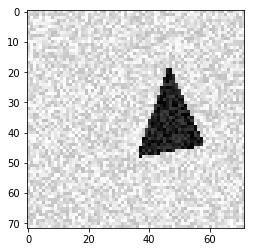

In [17]:
plt.imshow(x_test_noise[j].reshape(72,72), cmap='gray')

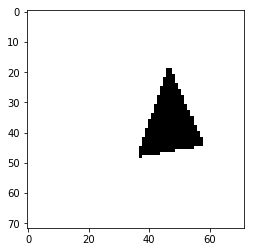

In [18]:
plt.imshow(x_test_clean[j].reshape(72,72), cmap='gray')

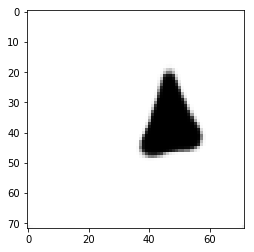

In [19]:
plt.imshow(x_pred_noise[j].reshape(72,72), cmap='gray')